# Lab 2

##### Team Members: Chad Kwong, Alex Lopez, Chris Haub, Erin McClure-Price

For this project, we chose to use the "Bank Marketing Data Set" that is stored in the Machine Learning Repository by the University of California, Irvine. The initial purpose of the data was to predict whether a customer would subscribe to a long-term deposit, which would allow the institution to better pursue those customers specifically. The data set contains 21 attributes and 41,188 instances collected via a telephone marketing campaign led by a “Portuguese banking institution” (Moro et al June 2014). While the data set only contains one prescribed target outcome (Long Term Deposits), we chose to additionally perform a second predicition. The second prediction we decided to create was what level of education (i.e., college and above, or highschool and below) is associated with increased potential of taking a long-term deposit. 

To predict our two desired outcomes, we constructed models using our chosen predictors from the available dataset. We hypothesized that success from our models would increase the efficiency of our telemarketing team regarding long-term deposits. In addition, the type of customer who is likely to take a long-term deposit can be readily distinguished and targeted, thereby increasing the number of long-term deposits held by the institution.

(S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014)

Loading packages needed for the project.

In [78]:
# Importing all packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import glob
import os
import seaborn as sns #may not use
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import paired_ttest_5x2cv

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

## Data Preparation

### Part 1

***Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.***

The first step was to load necessary packages and our dataset, UCI's "Bank Marketing Data Set" (https://archive.ics.uci.edu/ml/datasets/bank+marketing). In addition, we created variables for indexing both the continuous and categorical variables within the dataset.

In [2]:
#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

catCol = ['job', 'marital', 'education', 'housing', 'loan', 
          'contact', 'month', 'day_of_week'] # Default is removed from this list because it is not used 

The next step was to drop entries with missing values, this removed 10,701 rows leaving 30,488 rows which, as discussed in previous assignments, was sufficient for the analysis requirements. In addition, we removed those columns that were imbalanced or appeared to have little to no importance within the model. The removed columns included 'duration', 'default', 'pdays', and 'poutcome'.

The reasoning for removing the 'duration' and 'default' columns was that the former's distribution was highly skewed and just describes the time spent on the call, which cannot be known until after the call is ended. Obviously, those callers who take out a long-term deposit will naturally spend more time on a call, which indicates that this variable is likely to bias the results of a model. The latter was removed due to its consisting of almost entirely "no" responses with a total of 3 "yes" responses, making it highly imbalanced which infers that it would also bias any results. We ultimately chose to remove 'pdays' because it refers to how many days had passed since a customer had been contacted during the previous campaign, and did not appear to be relevant. In addition, the dataset is skewed since the majority of the customers in this dataset chose "no" to a term deposit and we wanted to dedicate our resources to those customers who had said "yes".

Finally, we chose to remove the 'poutcome' variable. This was done because the variable had three levels, "failure", "nonexistent", and "success", which indicated that only a single level was relevant to our predictions. As we stated above, we chose to focus our resources on creating a model that was not heavily weighted towards those customers who either were not contacted or who said "no" to a term deposit.


In [3]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

#Removing missing values
bankData2 = bankData.dropna()

print(getCP(bankData2.poutcome))

#Refining dataframe to focus on population that has no previous campaigns
bankData2 = bankData2.drop(bankData2[(bankData2.poutcome!='nonexistent') ].index)
print(getCP(bankData2.poutcome))

#Creating df of removed rows for optional analysis
previousCampaigns = bankData2.drop(bankData2[(bankData2.poutcome == 'nonexistent') ].index)

#Removing default, duration, pdays, and poutcome columns
bankData2 = bankData2.drop(['default','duration', 'pdays', 'poutcome'], axis=1)
print(bankData2.shape)
bankData2.head()

             Counts  Percent of Total
nonexistent   25836          0.847415
failure        3461          0.113520
success        1191          0.039065
             Counts  Percent of Total
nonexistent   25836               1.0
(25836, 17)


,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no


We looked at the simple statistics of the continuous variables and noted that the means were close to the medians, indicating that their distributions were fairly symmetrical and would not require any mathematical treatments prior to analysis.

In [4]:
#Getting basic statistical overview of continuous variables using the describe function
bankData2.describe()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,25836.000000,25836.000000,25836.0,25836.000000,25836.000000,25836.000000,25836.000000,25836.000000
mean,38.842081,2.624361,0.0,0.238470,93.592630,-40.452427,3.814680,5176.048192
std,9.904549,2.880938,0.0,1.512054,0.557312,4.458733,1.643046,66.103034
min,18.000000,1.000000,0.0,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,1.000000,0.0,-1.800000,93.200000,-42.700000,1.410000,5099.100000
50%,37.000000,2.000000,0.0,1.100000,93.876000,-41.800000,4.858000,5195.800000
75%,45.000000,3.000000,0.0,1.400000,93.994000,-36.400000,4.962000,5228.100000
max,95.000000,43.000000,0.0,1.400000,94.767000,-26.900000,5.045000,5228.100000


Looking at the first target variable, y, we see that it is remarkably imbalanced with over 25,000 "no" responses and less than 5,000 "yes" responses. While we could balance the target variable to even out the responses, we felt that increasing the "yes" answers would bias the outcomes of the models. Since the "no" responses are real we chose not to balance the variable in order to obtain more realistic models.

Percentages for  Y  : 
      Counts  Percent of Total
no    23264          0.900449
yes    2572          0.099551 




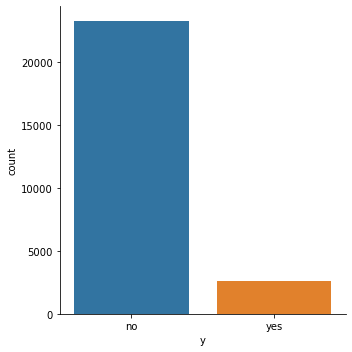

In [5]:
print("Percentages for ",'Y'," : \n",getCP(bankData2['y']),"\n\n")
sns.catplot(x='y', data = bankData2, kind = 'count')

Our second target variable, education, consists of seven levels: illiterate, basic 4, 6, and 9 years, highschool, university degree, and professional course. We noted that the majority of customers had a university degree (34%), followed by highschool (25%). The basic 9 year (14%) and professional course (14.1%) were fairly close followed by basic 4 year (8%) and then basic 6 year (5%). The illiterate level was 0.0004%. Since the differences were slightly imbalanced, especially true for the 'illiterate' level, we chose to divide this variable into 'College or Above' and 'Below College' in order to make it binary and to even out the responses *(code shown in Part 2)*. As shown in the figure below, this created roughly equal levels in the variable. 


The following is a breakdown of the class counts of the Education Variable:

 university.degree      8777
high.school            6458
professional.course    3699
basic.9y               3682
basic.4y               2008
basic.6y               1202
illiterate               10
Name: education, dtype: int64


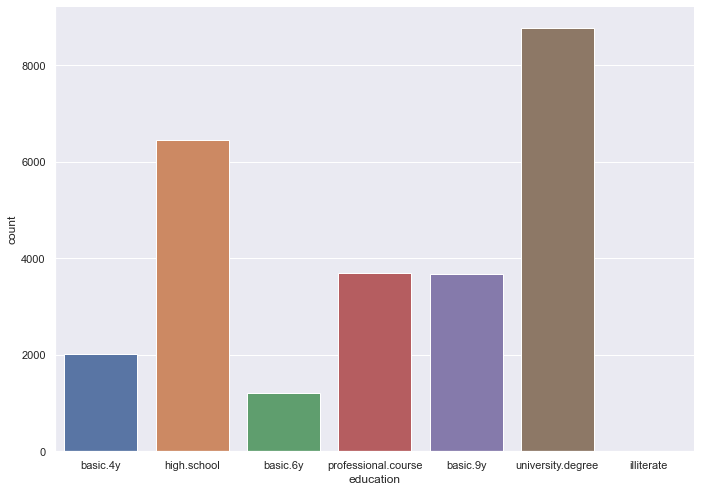

In [6]:
print("The following is a breakdown of the class counts of the Education Variable:\n\n",bankData2.education.value_counts())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(x='education', data = bankData2, kind = 'count', height=7, aspect=11.7/8.27)

The code below returns the counts and percentages of each level in the categorical variables. For jobs, most customers are in admin (28%) followed by blue-collar (19%) and technician (18%). The marital status for the majority of customers is married (57%), followed by single (31%), and divorced (12%). There were more customers with university degrees (34%) than all other levels of education, while the those customers who had housing loans (54%) were close to those without housing loans (46%).

From looking at the loan variable, we noted that only 16% of customers had taken out a personal loan, and from the contact variable we saw that the majority of customers used cellphones (67%) over telephones.

Interestingly, significantly more customers were contacted in the month of May (32%) than any other month, though we cannot make any inferences about why this would be the case since it is likely due to the bank's protocols. The day of the week did not appear to have any influence on customer count, while the variable for outcome of the previous marketing campaign, poutcome, did show that the majority of customers had nonexistent outcomes (85%).


In [7]:
# #Uncomment this code to see breakdowns of the variables in terms of class distribution
# for i in catCol:
#     print("Percentages for ",i," : \n",getCP(bankData2[i]),"\n\n")

We performed one hot encoding on the categorical variables and stored the resulting dataset as a separate dataset before concatenating it with the continuous variables from the cleaned dataset.

The next step was to normalize and finalize preparing the dataset. We used SciKit's StandardScaler, which would fix any non-Gaussian curves to center around zero and force all standard deviations to one.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [8]:
#Declaring Scalar object
scl_obj = StandardScaler()

#One hot encoding of ALL categorical variables
OneHotDF = pd.get_dummies(bankData2[catCol],drop_first=False)

#Scaling non-encoded data
conVar = bankData2.select_dtypes(exclude='object')
colnames = pd.Series(conVar.columns)
conVarScaled = scl_obj.fit_transform(conVar)
conVarScaled = pd.DataFrame(data = conVarScaled, columns= colnames)

#Combining with continuous variables from cleaned dataset
OneHotDF = OneHotDF.reset_index()
OneHotDF.pop('index')
OneHotDF = pd.concat([conVarScaled,OneHotDF], axis = 1)
OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,1.732361,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,1,0,0,0,0,1,0,0,0
1,-0.185987,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.116910,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,1,0,...,0,1,0,0,0,0,1,0,0,0
3,1.732361,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,1,0,0,0,0,1,0,0,0
4,2.035258,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,1,0,...,0,1,0,0,0,0,1,0,0,0


As stated in Part 1, the second target variable, 'education', had seven levels and we chose to convert it into a binary variable with two levels: 'College and Above', which included those customers with a university degree or professional experience, and 'Below College', which included those customers with a highschool diploma or less.

After dividing the education variable, we one hot encoded it to contain numeric entries only.

In [9]:
with warnings.catch_warnings(record=True):
    # Creating separate dataset for predicting education
    educData = bankData2

    # Converting target to binary: 0 for below college education, 1 for above or =
    educTarget = educData.education
    educTarget.loc[educTarget=='university.degree'] = 'College or Above'
    educTarget.loc[educTarget=='professional.course'] = 'College or Above'
    educTarget.loc[educTarget != 'College or Above'] = 'Below College'
    print(getCP(educTarget))

    educData = educData.drop(columns='education')

    catCol = ['job', 'marital', 'housing', 'loan', 
              'contact', 'month', 'day_of_week','y']

    oneHotEduc = pd.get_dummies(educData[catCol],drop_first=False)
    oneHotEduc = oneHotEduc.reset_index()
    oneHotEduc = pd.concat([conVarScaled,oneHotEduc], axis = 1)
    oneHotEduc.head()


                  Counts  Percent of Total
Below College      13360          0.517108
College or Above   12476          0.482892


### Part 2

***Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).***

As previously stated, the final and cleaned dataset we used had all rows with missing data removed removed mainly because the large size of the original data set allowed us to do so while maintaining the assignment's requirements. This meant that rather than trying to impute categorical variables, we could simply remove those rows while still meeting our instance size requirements. In addition, we removed four columns: 'duration', 'default', 'pdays', and 'poutcome' because they were either heavily imbalanced skewed with negative responses towards the campaign.

After the missing instances and unnecessary variables were removed, we one hot encoded the categorical features so that we could work with only numeric features. This format is required for certain modeling algorithms that we planned to utilize for the analysis.

Next, the data set was converted from a data frame to a list format. This was done in order to satisfy the cross validation training algorithim that requires this type of data input.

Finally, the numeric and list formatted data set was scaled which is required for many classifiers including, but not limited to, random forest and k-nearest neighbors.

## Modeling and Evaluation

### Part 1

***Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.***

For the goal of predicting the target variable, 'y', we chose to focus on precision because our goal was to minimize the number of false positives which, in turn, meant minimizing the potential loss of funds spent towards marketing. This last point is especially important because we would not want to direct a client to waste resources on customers who we predict will say "yes" to a loan when they will actually just say "no". Alternatively, if the marketing budget of a client was not a concern, focusing on recall would maximize potential customers saying "yes". In short, precision focuses on those customers who are most likely to choose "yes" to a term deposit, while recall focuses on maximizing potential returns. The reason why we chose precision over accuracy for this goal was because, as we previously showed, our target variable is imbalanced with approximately 87% "no" responses which infers that the accuracy of the model would be high but would also be biased towards over-predicting "no" responses.

For the goal of predicting the level of education a customer has that will make them more likely to say "yes" to a loan we chose to use accuracy. Our reasoning for using accuracy was that the target variable in this case, education, was balanced due to our dividing the levels into "College or Above" and "Below College". Since we did not have to worry about an imbalanced target variable we chose accuracy because we wanted to know the percentage of correct predictions.


### Part 2

***Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.***

An important aspect of choosing our method for the training/testing split was to analyze the distribution of our target variable. We did so by comparing the number of responses of each level within the target variable.

In [10]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

print("Percentages for Target variable, Y: \n\n",getCP(bankData2['y']),"\n\n")

Percentages for Target variable, Y: 

      Counts  Percent of Total
no    23264          0.900449
yes    2572          0.099551 




As stated in Part 1, the second target variable, 'education', had seven levels and we chose to convert it into a binary variable with two levels: "College and Above", which included those customers with a university degree or professional experience, and "Below College", which included those customers with a highschool diploma or less.

After dividing the education variable, we one hot encoded it to contain numeric entries only.

In [10]:
with warnings.catch_warnings(record=True):
    # Creating separate dataset for predicting education
    educData = bankData2

    # Converting target to binary: 0 for below college education, 1 for above or =
    educTarget = educData.education
    educTarget.loc[educTarget=='university.degree'] = 'College or Above'
    educTarget.loc[educTarget=='professional.course'] = 'College or Above'
    educTarget.loc[educTarget != 'College or Above'] = 'Below College'
    print(getCP(educTarget))

    educData = educData.drop(columns='education')

    catCol = ['job', 'marital', 'housing', 'loan', 
              'contact', 'month', 'day_of_week','y']

    oneHotEduc = pd.get_dummies(educData[catCol],drop_first=False)
    oneHotEduc = oneHotEduc.reset_index()
    oneHotEduc = pd.concat([conVarScaled,oneHotEduc], axis = 1)
    oneHotEduc.head()


                  Counts  Percent of Total
Below College      13360          0.517108
College or Above   12476          0.482892


The loop below sequentially trains and tests models for k-NN (neighbors = 5), random forest, and XGBoost. The plot below shows the results of the models via precision.

k-NN Mean Precision:  0.40524310380829026 
Random Forest Mean Precision:  0.4238559308254228 
XGBoost Mean Precision:  0.47480684923819794
CPU times: user 2min 36s, sys: 5.29 s, total: 2min 42s
Wall time: 45.8 s


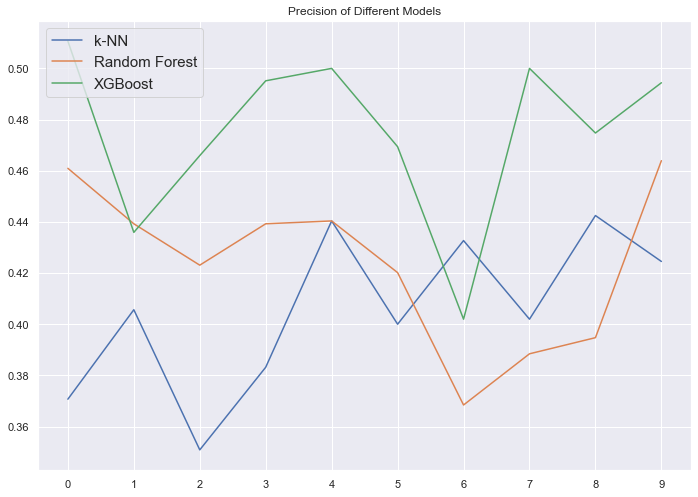

In [11]:
%%time

#Separating X values
x = OneHotDF
xVal = x.values

#Setting Parameters
randomState = 777
splits = 10
neighbors = 5

#Declaring CV object
cvStrat = StratifiedKFold(n_splits= splits, shuffle = True, random_state = randomState)

#Setting up basic models
knn = KNeighborsClassifier(n_neighbors = neighbors)
rf = RandomForestClassifier(random_state=randomState)
xgb = XGBClassifier(random_state=randomState, eval_metric='logloss')

#Separating target variable
y = bankData2['y']
y = y.ravel()

#Creating lists to store accuracy scores
knnAccs = []
rfAccs = []
xgbAccs = []

#Designating labels
labels = ['no', 'yes']

for trainIndices, testIndices in cvStrat.split(xVal,y): 
    
    #Term Subscription Prediction Testing/Training Splits
    xTrain = xVal[trainIndices]
    yTrain = y[trainIndices]
    yTrainBin = yTrain
    yTrainBin = (yTrainBin=='yes').astype(int)
    
    xTest = xVal[testIndices]
    yTest = y[testIndices]
    yTestBin = yTest
    yTestBin = (yTestBin=='yes').astype(int)
    
    #Scaled KNN training
    knn.fit(xTrain, yTrain) 
    yHatKnn = knn.predict(xTest)
    knnAccs.append(mt.precision_score(yTest,yHatKnn,pos_label='yes'))
    
    #Scaled XGBoost training
    xgb.fit(xTrain, yTrainBin)
    yHatXgb = xgb.predict(xTest)
    xgbAccs.append(mt.precision_score(yTestBin, yHatXgb, pos_label=1))
    
    #Scaled Random Forrest Training
    rf.fit(xTrain, yTrainBin)
    yhat = rf.predict(xTest)
    rfAccs.append(mt.precision_score(yTestBin, yhat, pos_label=1))

    
with warnings.catch_warnings(record=True):
    print("k-NN Mean Precision: ", pd.Series(knnAccs).mean(),
          "\nRandom Forest Mean Precision: ", pd.Series(rfAccs).mean(),
          "\nXGBoost Mean Precision: ", pd.Series(xgbAccs).mean()
         )
    normalPlot = plt.figure(1)
    
    knnAccs = pd.Series(data = knnAccs)
    knnAccs.plot()
    
    rfAccs = pd.Series(data = rfAccs)
    rfAccs.plot()
    
    xgbAccs = pd.Series(data = xgbAccs)
    xgbAccs.plot()
    
    plt.xticks(np.arange(0, splits, 1))
    plt.title("Precision of Different Models")
    plt.legend(loc="upper left", labels = ['k-NN', 'Random Forest','XGBoost'], prop={'size': 15})
    
    normalPlot.show()

The figure above showed that precision for the XGBoost was consistently higher with a mean of 48% while the random forest model had a mean of 41% which was slightly higher than the mean precision of the k-NN model at 42%. This indicates that the XGBoost model performed better than the alternatives, though the precision was still less than 50% which infers that the model is producing an increased number of false positives. We worked to increase precision and decrease the number of false positives later on.

The following code is a function for creating confusion matrices and printing performance metrics.

In [12]:
## setting up function to create confusion matrix
def make_confusion_matrix(model,y_actual, x_test, labels=[1, 0], noLabel = "No", yesLabel = "Yes"):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    
    actualNegative = "Actual -" + noLabel
    actualPositive = "Actual -" + yesLabel
    predictedNegative = "Predicted -" + noLabel
    predictedPositive = "Predicted -" + yesLabel
    
    y_predict = model.predict(x_test)
    cm=mt.confusion_matrix( y_actual, y_predict, labels=labels)
    df_cm = pd.DataFrame(cm, index = [i for i in [actualNegative,actualPositive]],
                  columns = [i for i in [predictedNegative,predictedPositive]])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Function for generating metric scores
def get_metrics_score(model,flag=True, xTrainSet = xTrain, yTrainSet = yTrain, xTestSet = xTest, yTestSet = yTest, yesLabel = 'yes'):    #model : classifier to predict values of X
    
    # defining an empty list to store train and test results
    score_list=[]
    
    #Predicting on train and tests
    pred_train = model.predict(xTrainSet)
    pred_test = model.predict(xTestSet)
    
    #Accuracy of the model
    train_acc = model.score(xTrainSet,yTrainSet)
    test_acc = model.score(xTestSet,yTestSet)
    
    #Recall of the model
    train_recall = mt.recall_score(yTrainSet,pred_train,pos_label=yesLabel)
    test_recall = mt.recall_score(yTestSet,pred_test,pos_label=yesLabel)
    
    #Precision of the model
    train_precision = mt.precision_score(yTrainSet,pred_train,pos_label=yesLabel)
    test_precision = mt.precision_score(yTestSet,pred_test,pos_label=yesLabel)

    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(xTrainSet,yTrainSet))
        print("Accuracy on test set : ",model.score(xTestSet,yTestSet))
        print("\nRecall on training set : ",mt.recall_score(yTrainSet,pred_train,pos_label=yesLabel))
        print("Recall on test set : ",mt.recall_score(yTestSet,pred_test,pos_label=yesLabel))
        print("\nPrecision on training set : ",mt.precision_score(yTrainSet,pred_train,pos_label=yesLabel))
        print("Precision on test set : ",mt.precision_score(yTestSet,pred_test,pos_label=yesLabel))
    
    return score_list # returning the list with train and test scores

We used the same loop that was created for analyzing the first target variable 'y' to analyze the the second target variable, education.

k-NN Mean Accuracy:  0.5737740753126239 
Random Forest Mean Accuracy:  0.7699337415753635 
XGBoost Mean Accuracy:  0.7695470593029682
CPU times: user 2min 41s, sys: 5.45 s, total: 2min 46s
Wall time: 51.3 s


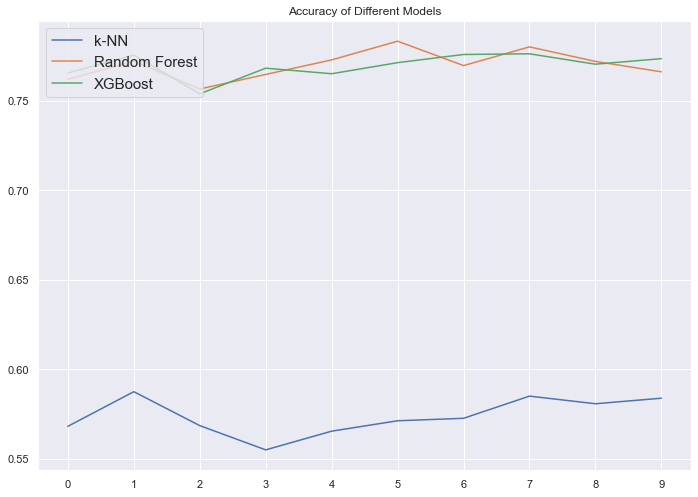

In [13]:
%%time
educVal = oneHotEduc.values
educY = educTarget.ravel()

#Creating lists to store accuracy scores
knnAccs = []
rfAccs = []
xgbAccs = []

#Creating Models for Multiclass
knn = KNeighborsClassifier(n_neighbors = neighbors)
rf = RandomForestClassifier(random_state=randomState)
xgb = XGBClassifier(random_state=randomState, eval_metric='logloss')

for trainIndices, testIndices in cvStrat.split(educVal,educY):     
    #Education Prediction Testing/Training Splits
    educXTrain = educVal[trainIndices]
    educXTest = educVal[testIndices]

    educYTrain = educY[trainIndices]
    educYTest = educY[testIndices]
    educYTrainBin = pd.get_dummies(educYTrain).values.argmax(1)
    educYTestBin = pd.get_dummies(educYTest).values.argmax(1)
    
    #k-NN training
    knn.fit(educXTrain, educYTrain) 
    yHatKnn = knn.predict(educXTest)
    knnAccs.append(mt.accuracy_score(educYTest,yHatKnn))
    
    #XGBoost training
    xgb.fit(educXTrain, educYTrainBin)
    yHatXgb = xgb.predict(educXTest)
    xgbAccs.append(mt.accuracy_score(educYTestBin, yHatXgb))
    
    #Random Forrest Training
    rf.fit(educXTrain, educYTrainBin)
    rfAccs.append(rf.score(educXTest, educYTestBin))
    
with warnings.catch_warnings(record=True):
    print("k-NN Mean Accuracy: ", pd.Series(knnAccs).mean(),
          "\nRandom Forest Mean Accuracy: ", pd.Series(rfAccs).mean(),
          "\nXGBoost Mean Accuracy: ", pd.Series(xgbAccs).mean()
         )
    
    normalPlot = plt.figure(1)
    
    knnAccs = pd.Series(data = knnAccs)
    knnAccs.plot()
    
    rfAccs = pd.Series(data = rfAccs)
    rfAccs.plot()
    
    xgbAccs = pd.Series(data = xgbAccs)
    xgbAccs.plot()
    
    plt.xticks(np.arange(0, splits, 1))
    plt.title("Accuracy of Different Models")
    plt.legend(loc="upper left", labels = ['k-NN', 'Random Forest','XGBoost'], prop={'size': 15})
    
    normalPlot.show()

By analyzing the mean accuracies of the models created to evaluate the 'education' variable, we saw that random forest and XGBoost had, essentially, the same accuracy of 77%. These models performed significantly better than the k-NN model which had an accuracy of 57%.

### Part 3

***Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!***

#### Random Forest: Term Deposit

In [14]:
# Baseline Model with no Tuning
rf=RandomForestClassifier(random_state=10)
rf.fit(xTrain, yTrainBin)

RandomForestClassifier(random_state=10)

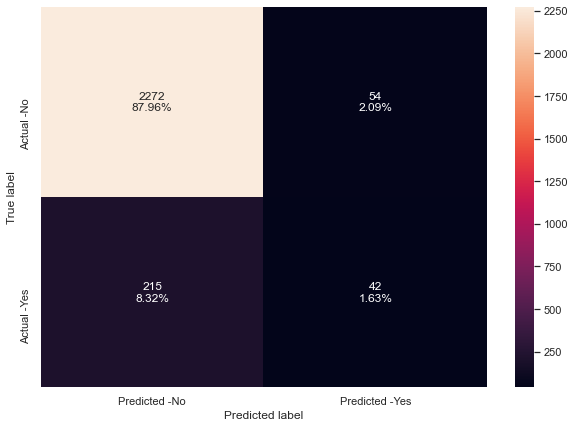

In [15]:
make_confusion_matrix(rf,yTestBin,xTest,labels=[0,1])

In [69]:
get_metrics_score(rf, yTrainSet = yTrainBin, yTestSet = yTestBin, yesLabel = 1)

rfPrecision = 0.4375

Accuracy on training set :  0.9925170945684428
Accuracy on test set :  0.8958575300038715

Recall on training set :  0.9421166306695464
Recall on test set :  0.16342412451361868

Precision on training set :  0.9819900945520036
Precision on test set :  0.4375


The baseline random forest model for predicting the first target variable 'y' (term deposit) showed that the model was overfit based on the training set precision value of 98%. When the test samples were applied to the model the precision dropped to 44%, confirming that the model was overfit. The next step was to hypertune the model and attempt to address the overfitting issue.

#### Random Forest Tuned: Term Deposit

The following code shows the results of the random forest model after hypertuning via grid search. For the hypertuning itself, we chose to modify the number of trees in the forest (n_estimators), the minimum number of samples required to for leaf node creation (min_samples_leaf), the max number of features to consider when determining the best splits (max_features), and the max number of samples required for the base estimator (max_samples) in order to account for more variation and improve performance. The results of the grid search hypertuning showed that our model was no longer overfitted since the precision for the training set (61%) was almost equal to the precision of our test set (63%). However, the hypertuning did increase computation time from a few seconds to over 13 minutes.

In [17]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    rf_tuned = RandomForestClassifier(random_state=10)

    # Grid of parameters to choose from

    parameters = {
        "n_estimators": [100,150,200],
        "min_samples_leaf": np.arange(5, 15, 5),
        "max_features": np.arange(0.2, 0.6, 0.1),
        "max_samples": np.arange(0.2, 0.6, 0.1),
                 }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.precision_score)

    # Run the grid search
    grid_obj = GridSearchCV(rf_tuned, parameters, scoring=acc_scorer,cv=5)
    grid_obj = grid_obj.fit(xTrain, yTrainBin)

    # Set the clf to the best combination of parameters
    rf_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    rf_tuned.fit(xTrain, yTrainBin)

CPU times: user 13min 7s, sys: 11 s, total: 13min 18s
Wall time: 13min 26s


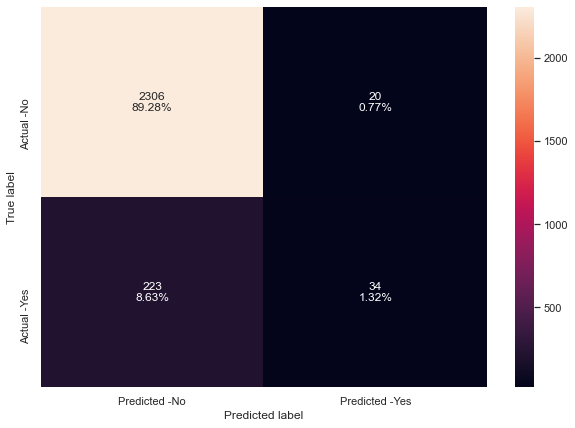

In [18]:
make_confusion_matrix(rf_tuned,yTestBin,xTest,labels=[0,1])

In [68]:
get_metrics_score(rf_tuned, yTrainSet = yTrainBin, yTestSet = yTestBin, yesLabel = 1)

rfTunedPrecision = 0.6296296296296297

Accuracy on training set :  0.904399432331312
Accuracy on test set :  0.9059233449477352

Recall on training set :  0.10971922246220302
Recall on test set :  0.13229571984435798

Precision on training set :  0.6105769230769231
Precision on test set :  0.6296296296296297


#### Random Forest: Education

In [20]:
# Baseline Model with no Tuning
rfEduc=RandomForestClassifier(random_state=10)
rfEduc.fit(educXTrain,educYTrainBin)

RandomForestClassifier(random_state=10)

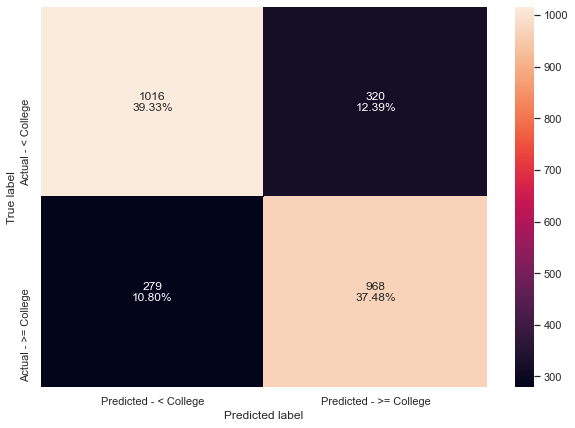

In [21]:
make_confusion_matrix(rfEduc,educYTestBin,educXTest,labels=[0, 1], noLabel = " < College", yesLabel = " >= College")

In [67]:
get_metrics_score(rfEduc, yTestSet = educYTestBin, xTrainSet = educXTrain, 
                  yTrainSet = educYTrainBin, xTestSet = educXTest, yesLabel = 1)

rfEducAccuracy = 0.7680991095625243

Accuracy on training set :  1.0
Accuracy on test set :  0.7680991095625243

Recall on training set :  1.0
Recall on test set :  0.7762630312750601

Precision on training set :  1.0
Precision on test set :  0.7515527950310559


The baseline random forest model for predicting the second target variable 'education' showed that the model had an accuracy of 77%. We hoped to improve this value through hypertuning, which is shown below.

#### Random Forest Tuned: Education

We applied hypertuning via grid search in the code below. For this model, we tuned the same parameters that were adjusted for the hypertuned random forest model. The results of the hypertuning showed that the accuracy actually decreased after hypertuning from 77% to 76%, which was surprising after seeing the results of the first target variable.

In [23]:
%%time
with warnings.catch_warnings(record=True):
    
    # Choose the type of classifier. 
    rfEduc_tuned = RandomForestClassifier(random_state=10)

    # Grid of parameters to choose from

    parameters = {
        "n_estimators": [150,200,250],
        "min_samples_leaf": np.arange(5, 20, 5),
        "max_features": np.arange(0.2, 0.5, 0.1),
        "max_samples": np.arange(0.1, 0.3, 0.1),
                 }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(rfEduc_tuned, parameters, scoring=acc_scorer,cv=3)
    grid_obj = grid_obj.fit(educXTrain,educYTrainBin)

    # Set the clf to the best combination of parameters
    rfEduc_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    rfEduc_tuned.fit(educXTrain,educYTrainBin)

CPU times: user 2min 54s, sys: 2.68 s, total: 2min 56s
Wall time: 2min 58s


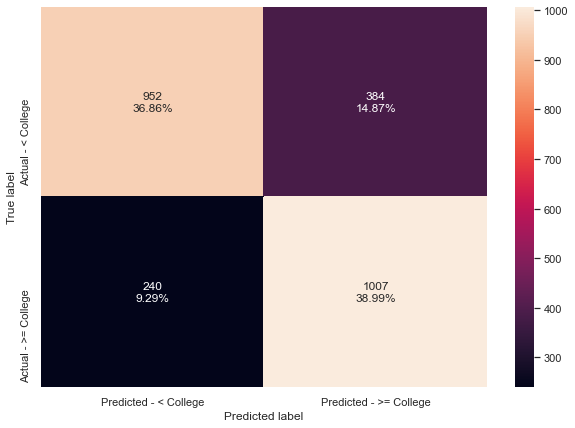

In [24]:
make_confusion_matrix(rfEduc_tuned,educYTestBin,educXTest,labels=[0, 1], noLabel = " < College", yesLabel = " >= College")

In [66]:
get_metrics_score(rfEduc_tuned, yTestSet = educYTestBin, xTrainSet = educXTrain, 
                  yTrainSet = educYTrainBin, xTestSet = educXTest, yesLabel = 1)

rfEducTunedAccuracy = 0.7584204413472706

Accuracy on training set :  0.7722874467810605
Accuracy on test set :  0.7584204413472706

Recall on training set :  0.8218897497550984
Recall on test set :  0.8075380914194066

Precision on training set :  0.7369051421271159
Precision on test set :  0.723939611790079


#### XGBoost: Term Deposit

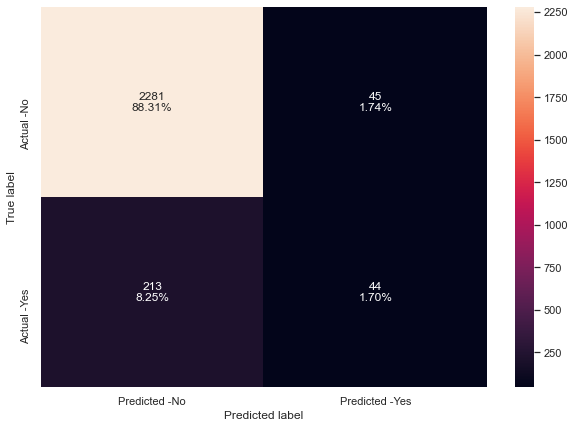

In [26]:
# Baseline Model before Tuning
xgb = XGBClassifier(random_state=10, eval_metric='logloss')
xgb.fit(xTrain,yTrainBin)
make_confusion_matrix(xgb,yTestBin,xTest,labels=[0,1])

In [65]:
get_metrics_score(xgb, yTrainSet = yTrainBin, yTestSet = yTestBin, yesLabel = 1)

xgbPrecision = 0.4943820224719101

Accuracy on training set :  0.9324388250978368
Accuracy on test set :  0.9001161440185831

Recall on training set :  0.36285097192224625
Recall on test set :  0.17120622568093385

Precision on training set :  0.8974358974358975
Precision on test set :  0.4943820224719101


Analysis of the XGBoost baseline model for predicting 'y' (term deposit) showed that, similar to the random forest model, we suffered from overfitting with a training set precision of 90% and a test set precision of 50%. We chose to apply hypertuning again in order to create a more realistic model.

#### Tuned XG Boost: Term Deposit

After hypertuning the parameters of the baseline XGBoost model, we found that precision had decreased to a more realistic 61% for the training set, while the more test set had increased to 80%. Since the test set is the better gauge of the performance of the model, we were satisfied that our model was performing better.

In [32]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    xgb_tuned = XGBClassifier(random_state=10, eval_metric = 'logloss')

    # Grid of parameters to choose from
    ## add from
    parameters = {
        "n_estimators": np.arange(1,4,2),
        #"scale_pos_weight":[0,1,2],
        "subsample":[0.25,0.5],
        "learning_rate":[0.0001,0.001],
        "gamma":[0,1,3],
        "colsample_bytree":[0.3,0.5,0.7,0.9],
        "colsample_bylevel":[0.5,1]
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.precision_score)

    # Run the grid search
    grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=3)
    grid_obj = grid_obj.fit(xTrain, yTrainBin)

    # Set the clf to the best combination of parameters
    xgb_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    xgb_tuned.fit(xTrain, yTrainBin)

CPU times: user 2min 12s, sys: 2.94 s, total: 2min 15s
Wall time: 18.4 s


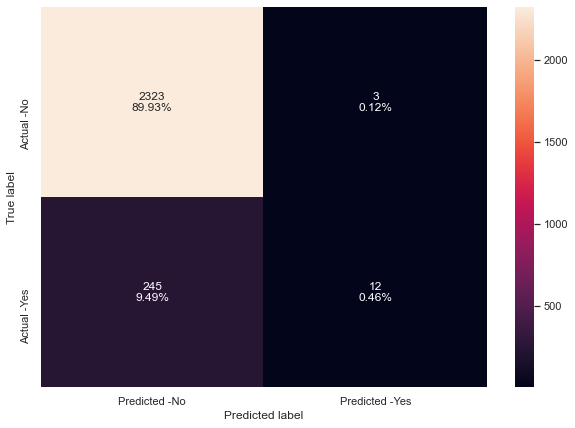

In [29]:
make_confusion_matrix(xgb_tuned,yTestBin,xTest,labels=[0,1])

In [64]:
get_metrics_score(xgb_tuned, yTestSet = yTestBin, 
                  yTrainSet = yTrainBin, yesLabel = 1)

xgbTunedPrecision = 0.8

Accuracy on training set :  0.9021201565389412
Accuracy on test set :  0.9039876113046845

Recall on training set :  0.045788336933045355
Recall on test set :  0.04669260700389105

Precision on training set :  0.6127167630057804
Precision on test set :  0.8


#### XGBoost: College Education

In [35]:
%%time
# Baseline Model before Tuning
xgbEduc = XGBClassifier(random_state=10, eval_metric='logloss')
xgbEduc.fit(educXTrain,educYTrainBin)

CPU times: user 10.9 s, sys: 199 ms, total: 11.1 s
Wall time: 1.69 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, ...)

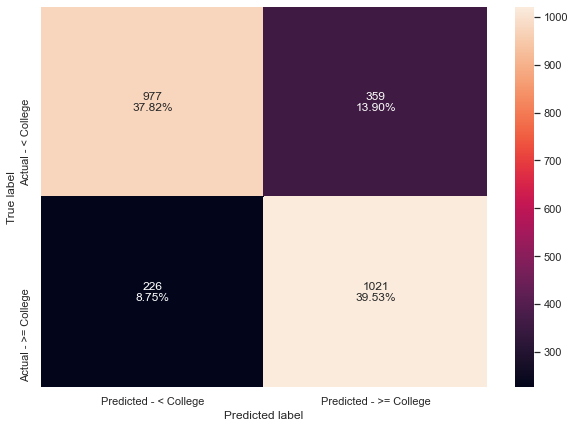

In [36]:
make_confusion_matrix(xgbEduc,educYTestBin,educXTest,labels=[0, 1],
                      noLabel = " < College", yesLabel = " >= College")

In [63]:
get_metrics_score(xgbEduc, yTestSet = educYTestBin, yTrainSet = educYTrainBin, 
                  xTrainSet = educXTrain, xTestSet = educXTest, yesLabel = 1)
xgbEducAccuracy = 0.7735191637630662

Accuracy on training set :  0.8372683094654453
Accuracy on test set :  0.7735191637630662

Recall on training set :  0.883248730964467
Recall on test set :  0.8187650360866079

Precision on training set :  0.8004196594302316
Precision on test set :  0.7398550724637681


The baseline XGBoost model for predicting the level of education produced an accuracy value of 77%. Once again, we chose to apply grid search in order to hypertune the parameters; the approach taken was the same described for the random forest model for predicting the term deposit variable.

#### Tuned XGBoost: College Education

Unfortunately, hypertuning the XGBoost model for predicting the education level decreased the accuracy of the model from 77% to 73%, indicating that hypertuning was not beneficial to improving the outcome of the model.

In [40]:
%%time
    # Choose the type of classifier. 
    xgbEducTuned = XGBClassifier(random_state=10,eval_metric='logloss')

    # Grid of parameters to choose from
    ## add from
    parameters = {
        "n_estimators": np.arange(1,4,2),
        #"scale_pos_weight":[0,1,2],
        "subsample":[0.25,0.5],
        "learning_rate":[0.0001,0.001],
        "gamma":[0,1,3],
        "colsample_bytree":[0.3,0.5,0.7,0.9],
        "colsample_bylevel":[0.5,1]
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(xgbEducTuned, parameters,scoring=acc_scorer,cv=3)
    grid_obj = grid_obj.fit(educXTrain, educYTrainBin)

    # Set the clf to the best combination of parameters
    xgbEducTuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgbEducTuned.fit(educXTrain, educYTrainBin)

CPU times: user 2min 7s, sys: 3.52 s, total: 2min 10s
Wall time: 18.5 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0001, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=10, reg_alpha=0, reg_lambda=1, ...)

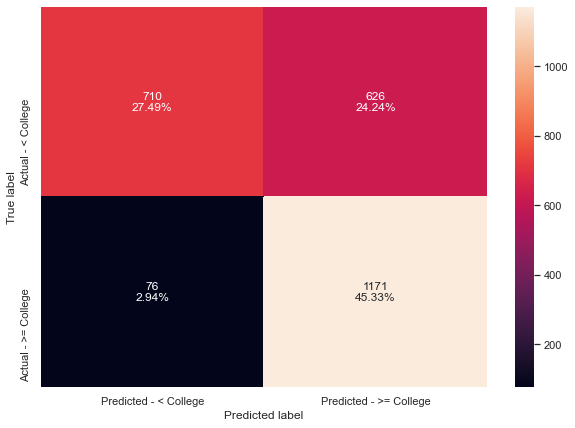

In [41]:
make_confusion_matrix(xgbEducTuned,educYTestBin,educXTest,labels=[0,1], 
                      noLabel = ' < College', yesLabel = ' >= College')

In [62]:
get_metrics_score(xgbEducTuned, xTrainSet = educXTrain, xTestSet = educXTest, 
                  yTestSet = educYTestBin, yTrainSet = educYTrainBin, yesLabel = 1)

xgbEducTunedAccuracy = 0.7282229965156795

Accuracy on training set :  0.7340558207543113
Accuracy on test set :  0.7282229965156795

Recall on training set :  0.9381957431650192
Recall on test set :  0.9390537289494787

Precision on training set :  0.6574102964118564
Precision on test set :  0.6516416249304396


#### KNN: Term Deposit

For our final investigational model, the baseline k-NN model for predicting the term deposit variable performed with an accuracy of 42%. We then iterated through different K values to find the optimal k. 

In [124]:
%%time
knnDef = KNeighborsClassifier()
knnDef.fit(xTrain, yTrain)
preds = knnDef.predict(xTest)
knnPrecision = mt.precision_score(yTest,preds, pos_label = 'yes')
print('Default model precision: ', knnPrecision)

Default model precision:  0.42452830188679247
CPU times: user 1.62 s, sys: 400 ms, total: 2.02 s
Wall time: 1.12 s


The maximum accuracy in the range of 1 to 101 neighbors is 0.90708479
The mean accuracy for the selected neighbor range is: 0.9020441347270614 .

The maximum precision score in the range of 1 to 101 neighbors is 0.72972973
The mean precision score for the selected neighbor range is: 0.9020441347270614 .
The accuracy of the model with the highest precision is 0.90708479

The maximum recall score in the range of 1 to 101 neighbors is 0.25291829
The mean recall score for the selected neighbor range is: 0.1071595330739299 .
The accuracy of the model with the highest recall is 0.84707704 

CPU times: user 1min 20s, sys: 17.8 s, total: 1min 37s
Wall time: 54.7 s


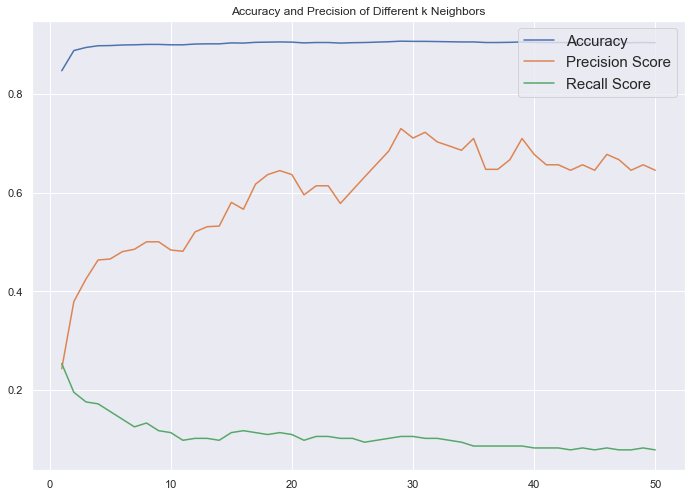

In [54]:
%%time
#Creating empty arrays for storing accuracies and precisions
knnAccs = []
knnPrecisions = []
knnRecalls = []

#setting neighbor range for future for loop to calculate best k
minNeighbors = 1
maxNeighbors = 101

modelcount = 1
modeliter = 2

#For loop to iterate through k values
for i in range(minNeighbors,maxNeighbors,modeliter):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(xTrain, yTrain) 
    yHatKnn = knn.predict(xTest)
    knnAccs.append(mt.accuracy_score(yTest,yHatKnn))
    knnPrecisions.append(mt.precision_score(yTest,yHatKnn,pos_label='yes'))
    knnRecalls.append(mt.recall_score(yTest,yHatKnn, pos_label='yes'))
    modelcount += 1

#Printing mean and max accuracy and index of max accuracy
knnAccs = pd.Series(data = knnAccs)
knnAccs.index = np.arange(minNeighbors, minNeighbors + len(knnPrecisions))
print("The maximum accuracy in the range of",minNeighbors,
      "to",maxNeighbors,"neighbors is",round(knnAccs.max(),8))
print("The mean accuracy for the selected neighbor range is:",knnAccs.mean(),".\n")

#Printing mean and max precision and index of max precision
knnPrecisions = pd.Series(data = knnPrecisions)
knnPrecisions.index = np.arange(minNeighbors, minNeighbors + len(knnPrecisions))
print("The maximum precision score in the range of",minNeighbors,
      "to",maxNeighbors,"neighbors is",round(knnPrecisions.max(),8))
print("The mean precision score for the selected neighbor range is:", knnAccs.mean(),".")
print("The accuracy of the model with the highest precision is", round(knnAccs[knnPrecisions.idxmax()], 8))

#Printing mean and max recall and index of max recall
knnRecalls = pd.Series(data = knnRecalls)
knnRecalls.index = np.arange(minNeighbors, minNeighbors + len(knnPrecisions))
print("\nThe maximum recall score in the range of",minNeighbors,
      "to",maxNeighbors,"neighbors is",round(knnRecalls.max(),8))
print("The mean recall score for the selected neighbor range is:",knnRecalls.mean(),".")
print("The accuracy of the model with the highest recall is", round(knnAccs[knnRecalls.idxmax()], 8),"\n")

#Plotting accuracies and precision scores for different neighbor values
normalPlot = plt.figure(1)

#K plots
knnAccs.plot()
knnPrecisions.plot()
knnRecalls.plot()

plt.title("Accuracy and Precision of Different k Neighbors")
plt.legend(loc="upper right", labels = ['Accuracy', 'Precision Score', 'Recall Score'], prop={'size': 15})

From the code above, we found the optimal K value of 169. With our optimal value, we then used a grid search to configure the best performing model that would maximize accuracy.

In [89]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    knnTuned = KNeighborsClassifier(n_neighbors = 169)

    # Grid of parameters to choose from
    ## add from
    parameters = {
        "metric":['euclidean', 'cityblock','cosine',
                  'haversine','l1','l2','manhattan','nan_euclidean'],
        "p": np.arange(1,3,1)
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score, pos_label="College or Above")

    # Run the grid search
    grid_obj = GridSearchCV(knnTuned, parameters,scoring=acc_scorer,cv=2)
    grid_obj = grid_obj.fit(xTrain, yTrainBin)

    # Set the clf to the best combination of parameters
    knnTuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
print(knnTuned.fit(xTrain,yTrainBin))

KNeighborsClassifier(metric='euclidean', n_neighbors=169, p=1)
CPU times: user 3min 20s, sys: 29.1 s, total: 3min 49s
Wall time: 3min 17s


In [122]:
yHatKnn = knnTuned.predict(xTest)
knnTunedPrecision = mt.precision_score(yTest,yHatKnn, pos_label = 'yes')
print("\n",knnTunedPrecision)


 0.6153846153846154


From our grid search, we optimized our model to return an accuracy of about 61.5%.

#### KNN: College Education

In [53]:
%%time
knnDef.fit(educXTrain, educYTrain)
preds = knnDef.predict(educXTest)
knnEducAccuracy = mt.accuracy_score(educYTest,preds)
print('Default model accuracy: ', knnEducAccuracy)

Default model accuracy:  0.5838172667440961
CPU times: user 1.93 s, sys: 399 ms, total: 2.33 s
Wall time: 1.44 s


The maximum accuracy in the range of 1 to 201 neighbors is 0.61827333
The mean accuracy for the selected neighbor range is: 0.6070731707317072 .

The maximum precision score in the range of 1 to 201 neighbors is 0.64035088
The mean precision score for the selected neighbor range is: 0.6070731707317072 .
The accuracy of the model with the highest precision is 0.61633759

The maximum recall score in the range of 1 to 201 neighbors is 0.56054531
The mean recall score for the selected neighbor range is: 0.4796551724137931 .
The accuracy of the model with the highest recall is 0.57607433 

CPU times: user 3min 10s, sys: 35 s, total: 3min 45s
Wall time: 2min 20s


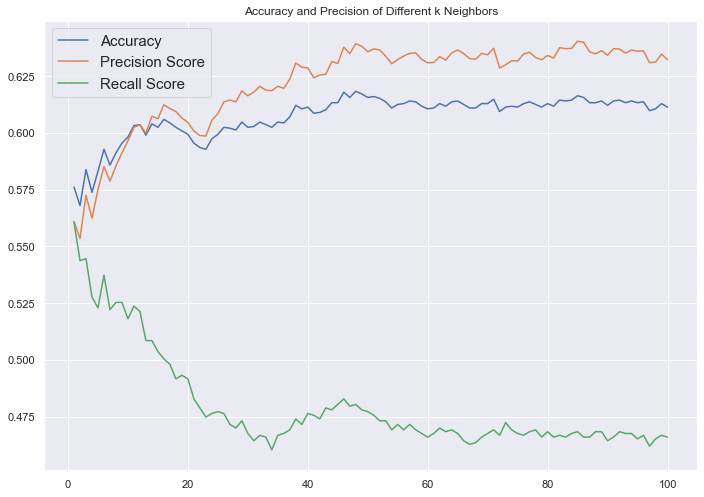

In [56]:
%%time
#Creating empty arrays for storing accuracies and precisions
knnEducAccs = []
knnEducPrecisions = []
knnEducRecalls = []

#setting neighbor range for future for loop to calculate best k
minNeighbors = 1
maxNeighbors = 201

modeliter = 2

#For loop to iterate through k values
for i in range(minNeighbors,maxNeighbors,modeliter):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(educXTrain, educYTrain) 
    yHatKnn = knn.predict(educXTest)
    knnEducAccs.append(mt.accuracy_score(educYTest,yHatKnn))
    knnEducPrecisions.append(mt.precision_score(educYTest,yHatKnn,pos_label='College or Above'))
    knnEducRecalls.append(mt.recall_score(educYTest,yHatKnn, pos_label='College or Above'))

#Printing mean and max accuracy and index of max accuracy
knnEducAccs = pd.Series(data = knnEducAccs)
knnEducAccs.index = np.arange(1, 1 + len(knnEducPrecisions))
print("The maximum accuracy in the range of",minNeighbors,
      "to",maxNeighbors,"neighbors is",round(knnEducAccs.max(),8))
print("The mean accuracy for the selected neighbor range is:",knnEducAccs.mean(),".\n")

#Printing mean and max precision and index of max precision
knnEducPrecisions = pd.Series(data = knnEducPrecisions)
knnEducPrecisions.index = np.arange(1, 1 + len(knnEducPrecisions))
print("The maximum precision score in the range of",minNeighbors,
      "to",maxNeighbors,"neighbors is",round(knnEducPrecisions.max(),8))
print("The mean precision score for the selected neighbor range is:", knnEducAccs.mean(),".")
print("The accuracy of the model with the highest precision is", round(knnEducAccs[knnEducPrecisions.idxmax()], 8))

#Printing mean and max recall and index of max recall
knnEducRecalls = pd.Series(data = knnEducRecalls)
knnEducRecalls.index = np.arange(1, 1 + len(knnEducPrecisions))
print("\nThe maximum recall score in the range of",minNeighbors,
      "to",maxNeighbors,"neighbors is",round(knnEducRecalls.max(),8))
print("The mean recall score for the selected neighbor range is:",knnEducRecalls.mean(),".")
print("The accuracy of the model with the highest recall is", round(knnEducAccs[knnEducRecalls.idxmax()], 8),"\n")

#Plotting accuracies and precision scores for different neighbor values
normalPlot = plt.figure(1)

#K plots
knnEducAccs.plot()
knnEducPrecisions.plot()
knnEducRecalls.plot()

plt.title("Accuracy and Precision of Different k Neighbors")
plt.legend(loc="best", labels = ['Accuracy', 'Precision Score', 'Recall Score'], prop={'size': 15})


Ideal K number is 169

In [46]:
%%time
knn = KNeighborsClassifier(n_neighbors = 169)
knn.fit(educXTrain, educYTrain) 
yHatKnn = knn.predict(educXTest)
mt.accuracy_score(educYTest,yHatKnn)

CPU times: user 1.91 s, sys: 323 ms, total: 2.23 s
Wall time: 1.38 s


0.616337591947348

In [95]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    knnEducTuned = KNeighborsClassifier(n_neighbors = 169)

    # Grid of parameters to choose from
    ## add from
    parameters = {
        "metric":['euclidean', 'cityblock','cosine',
                  'haversine','l1','l2','manhattan','nan_euclidean'],
        "p": np.arange(1,3,1)
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score, pos_label="College or Above")

    # Run the grid search
    grid_obj = GridSearchCV(knnEducTuned, parameters,scoring=acc_scorer,cv=2)
    grid_obj = grid_obj.fit(educXTrain, educYTrainBin)

    # Set the clf to the best combination of parameters
    knnEducTuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
print(knnEducTuned.fit(educXTrain,educYTrainBin))

KNeighborsClassifier(metric='euclidean', n_neighbors=169, p=1)
CPU times: user 3min 19s, sys: 27.3 s, total: 3min 46s
Wall time: 3min 14s


In [110]:
yHatKnn = knnEducTuned.predict(educXTest)
knnEducTunedAccuracy = mt.accuracy_score(educYTestBin,yHatKnn)
print("\n",knnEducTunedAccuracy)


 0.6035617499032133


The best distance metric is the default metric, minkowski.

### Part 4

***Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.***

In all cases for the first prediction variable 'y' (term deposit), the grid search-tuned models outperformed the baseline models. When comparing the tuned models, we found that the XGBoost performed best with a precision of 80%. The random forest model had the second best precision value at 63%, while the k-NN model performed the worst at 62%.

The baseline models (i.e., "default models") were substantially poorer, with precision values ranging from 42% to 44%. 

In [123]:
accuracies = pd.DataFrame({'Default Model': [rfPrecision, xgbPrecision, knnPrecision],
                           'Tuned Model': [rfTunedPrecision, xgbTunedPrecision, knnTunedPrecision]},
                          index = ['Random Forest', 'XGBoost', 'k-NN']
                         )
accuracies

,Default Model,Tuned Model
Random Forest,0.437500,0.629630
XGBoost,0.494382,0.800000
k-NN,0.424528,0.615385


When analyzing the results for the second target variable, 'education', we cound that the untuned XGBoost model had the best accuracy at 77%, while the tuned XGBoost accuracy was 73%. The next best performing models were the untuned random forest model (76.85) followed by the tuned k-NN model (60%).

In [115]:
precisions = pd.DataFrame({'Default Model': [rfEducAccuracy, xgbEducAccuracy, knnEducAccuracy],
                           'Tuned Model': [rfEducTunedAccuracy, xgbEducTunedAccuracy, knnEducTunedAccuracy]},
                          index = ['Random Forest', 'XGBoost', 'k-NN']
                         )

precisions

,Default Model,Tuned Model
Random Forest,0.768099,0.758420
XGBoost,0.773519,0.728223
k-NN,0.583817,0.603562


### Part 5

***Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.***

#### Term Deposit T Tests

Based on the code below, we see that there is a statistically significant difference at the 95% confidence level between the tuned and untuned models.

In [91]:
%%time
# T-Test: Term Deposit KNN
t, p = paired_ttest_5x2cv(estimator1=knnDef,estimator2=knnTuned,X=xTrain,y=yTrain)
alpha = 0.05



print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)



if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -3.406
aplha  0.05
p value: 0.019
Reject null hypotesis
CPU times: user 1min 19s, sys: 16.6 s, total: 1min 35s
Wall time: 1min 1s


In [85]:
# T-Test: Term Deposit RF
t, p = paired_ttest_5x2cv(estimator1=rf,estimator2=rf_tuned,X=xTrain,y=yTrainBin)
alpha = 0.05



print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)



if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -5.932
aplha  0.05
p value: 0.002
Reject null hypotesis


In [86]:
# T-Test: Term Deposit XGB
t, p = paired_ttest_5x2cv(estimator1=xgb,estimator2=xgb_tuned,X=xTrain,y=yTrainBin)
alpha = 0.05



print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)



if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -4.933
aplha  0.05
p value: 0.004
Reject null hypotesis


#### Education T Testing

Based on the results of the 95% confidence intervals for the tuned and untuned models, we saw that there were no differences between the education models for k-NN and random forest, while there was a difference for the XGBoost models.

In [97]:
# T-Test: Education KNN
t, p = paired_ttest_5x2cv(estimator1=knn,estimator2=knnEducTuned,X=educXTrain,y=educYTrainBin)
alpha = 0.05



print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)



if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -0.336
aplha  0.05
p value: 0.751
Fail to reject null hypotesis


In [98]:
# T-Test: Education RF
t, p = paired_ttest_5x2cv(estimator1=rfEduc,estimator2=rfEduc_tuned,X=educXTrain,y=educYTrainBin)
alpha = 0.05



print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)



if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: 0.431
aplha  0.05
p value: 0.685
Fail to reject null hypotesis


In [99]:
# T-Test: Education XGB
t, p = paired_ttest_5x2cv(estimator1=xgbEduc,estimator2=xgbEducTuned,X=educXTrain,y=educYTrainBin)
alpha = 0.05



print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)



if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: 6.928
aplha  0.05
p value: 0.001
Reject null hypotesis


## Part 6

***Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.***

The following figures provide a visual display of those variables that were most important to the analyses. For term deposit, it appears that financial market features have the most impact on whether customers will sign up for a term deposit. 

For the education prediction, it appeared that job and age had the largest impact on whether or not a customer had a college level education or lower. 

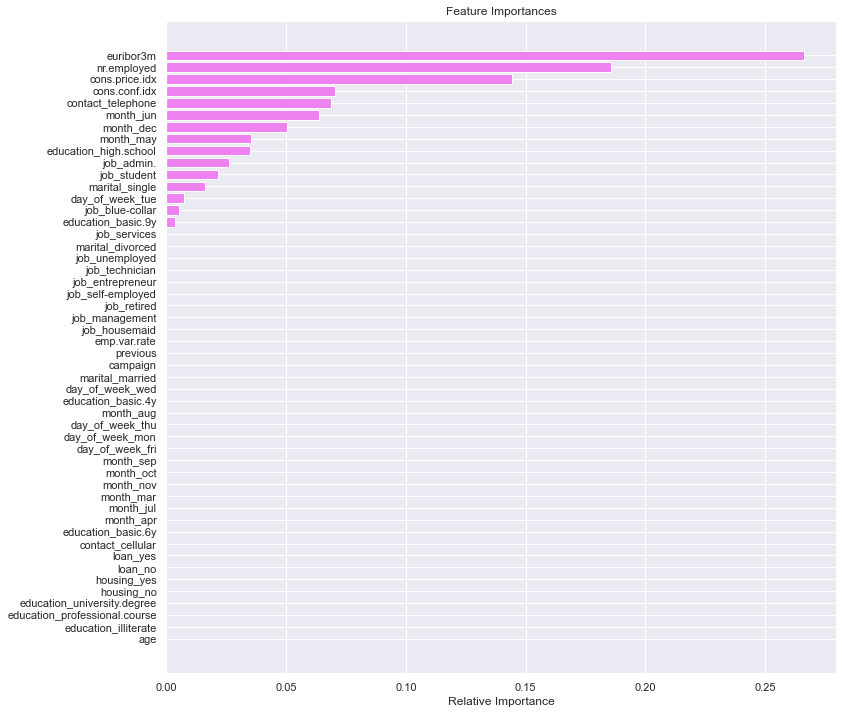

In [104]:
# plotting feature importance for tuned xgboost 
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(x.columns)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

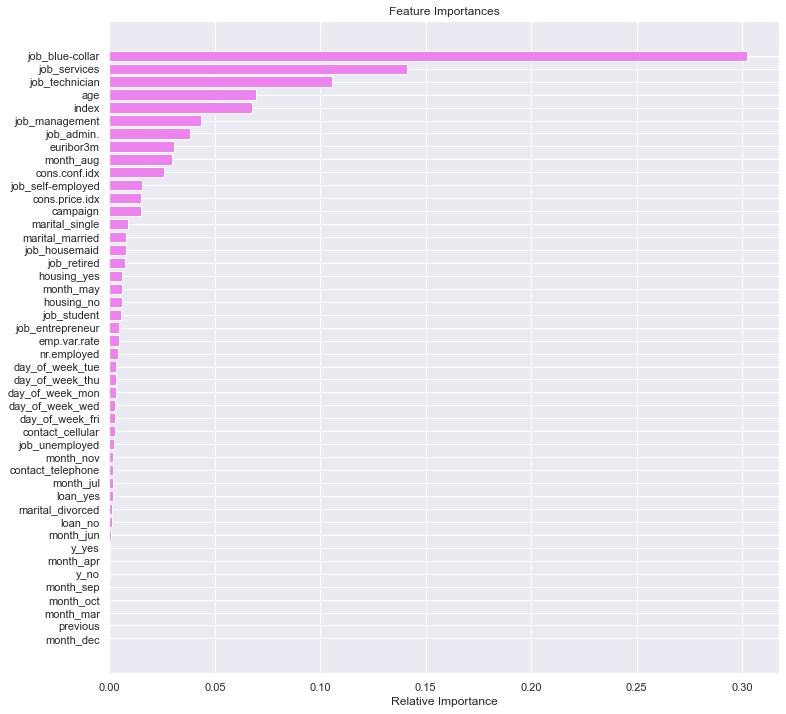

In [103]:
# plotting feature importance for Education tuned random forest model
importances = rfEduc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(oneHotEduc.columns)



plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Deployment

***How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?***

The initial purpose of the dataset was to predict whether a customer would subscribe to a long-term deposit, which would allow the institution to better pursue those customers specifically. We believe that our models would assist them by helping banks maximize their returns by focusing on those customers who were prediced to take on a term deposit while helping to reduce the funding spent on those customers who would were not likely to do so.

We would deploy our model/s by showing bank management the results from previous projects, such as this one, and explaining how we were able to assist their marketing department by statistically selecting those customers who were most likely willing to invest in a term deposit. 

Answering the question of what other data should be collected, we feel that adding variables for gender, experience of the caller (salesperson), and social and economic variables such as neighborhood and income, tax bracket, net worth, and quarterly capital gains would be beneficial. The gender and experience variables would provide insight into the customer's willingness to take a term deposit, while the social and economic variables seem like they would be strong indicators of whether or not a customer could afford a term deposit.

The model would need to be updated yearly, after each marketing campaign was was completed. This would ensure that our models were accurate and accounted for any customers who had changed their minds about taking a term deposit, thereby allowing us to remain on top of our prediction models.


## Exceptional Work

You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

## Grid Search
Grid search was used as a way of tuning as well as for exceptional work. This thouroughly produces candidates from a grid of parameter values. Multiple grids were explored. The estimator is fitted on the dataset, all the possible combinations of parameter values are evaluated to find the best value.

Grid Search: Random Forest Tuned: Term Deposit

In [27]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    rf_tuned = RandomForestClassifier(random_state=10)

    # Grid of parameters to choose from

    parameters = {
        "n_estimators": [100,150,200],
#         "min_samples_leaf": np.arange(5, 15, 5),
#         "max_features": np.arange(0.2, 0.6, 0.1),
#         "max_samples": np.arange(0.2, 0.6, 0.1),
                 }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.precision_score)

    # Run the grid search
    grid_obj = GridSearchCV(rf_tuned, parameters, scoring=acc_scorer,cv=5)
    grid_obj = grid_obj.fit(xTrain, yTrainBin)

    # Set the clf to the best combination of parameters
    rf_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    rf_tuned.fit(xTrain, yTrainBin)

CPU times: total: 35.3 s
Wall time: 35.7 s


Grid Search: Random Forest Tuned: Education

In [29]:
%%time
with warnings.catch_warnings(record=True):
    
    # Choose the type of classifier. 
    rfEduc_tuned = RandomForestClassifier(random_state=10)

    # Grid of parameters to choose from

    parameters = {
        "n_estimators": [150,200,250],
#         "min_samples_leaf": np.arange(5, 20, 5),
#         "max_features": np.arange(0.2, 0.5, 0.1),
#         "max_samples": np.arange(0.1, 0.3, 0.1),
                 }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(rfEduc_tuned, parameters, scoring=acc_scorer,cv=3)
    grid_obj = grid_obj.fit(educXTrain,educYTrainBin)

    # Set the clf to the best combination of parameters
    rfEduc_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    rfEduc_tuned.fit(educXTrain,educYTrainBin)

CPU times: total: 35.3 s
Wall time: 36 s


Grid Search: Tuned XG Boost: Term Deposit

In [ ]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    xgb_tuned = XGBClassifier(random_state=10, eval_metric = 'logloss')

    # Grid of parameters to choose from
    ## add from
    parameters = {
        "n_estimators": np.arange(1,4,2),
        #"scale_pos_weight":[0,1,2],
#         "subsample":[0.25,0.5],
#         "learning_rate":[0.0001,0.001],
#         "gamma":[0,1,3],
#         "colsample_bytree":[0.3,0.5,0.7,0.9],
#         "colsample_bylevel":[0.5,1]
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.precision_score)

    # Run the grid search
    grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=3)
    grid_obj = grid_obj.fit(xTrain, yTrainBin)

    # Set the clf to the best combination of parameters
    xgb_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    xgb_tuned.fit(xTrain, yTrainBin)

Grid Search:Tuned XGBoost: College Education

In [31]:
%%time
    # Choose the type of classifier. 
    xgbEducTuned = XGBClassifier(random_state=10,eval_metric='logloss')

    # Grid of parameters to choose from
    ## add from
    parameters = {
        "n_estimators": np.arange(1,4,2),
        #"scale_pos_weight":[0,1,2],
#         "subsample":[0.25,0.5],
#         "learning_rate":[0.0001,0.001],
#         "gamma":[0,1,3],
#         "colsample_bytree":[0.3,0.5,0.7,0.9],
#         "colsample_bylevel":[0.5,1]
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(xgbEducTuned, parameters,scoring=acc_scorer,cv=3)
    grid_obj = grid_obj.fit(educXTrain, educYTrainBin)

    # Set the clf to the best combination of parameters
    xgbEducTuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgbEducTuned.fit(educXTrain, educYTrainBin)

CPU times: total: 2.09 s
Wall time: 492 ms


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
Grid Search: Tuned k-NN: Education

In [33]:
%%time
with warnings.catch_warnings(record=True):
    # Choose the type of classifier. 
    knnTuned = KNeighborsClassifier(n_neighbors = 169)

    # Grid of parameters to choose from
    ## add from
    parameters = {
#         "metric":['euclidean', 'cityblock','cosine',
#                   'haversine','l1','l2','manhattan','nan_euclidean'],
        "p": np.arange(1,3,1)
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = mt.make_scorer(mt.accuracy_score, pos_label="College or Above")

    # Run the grid search
    grid_obj = GridSearchCV(knnTuned, parameters,scoring=acc_scorer,cv=2)
    grid_obj = grid_obj.fit(xTrain, yTrainBin)

    # Set the clf to the best combination of parameters
    knnTuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
print(knnTuned.fit(xTrain,yTrainBin))
print("\n",mt.accuracy_score(yTest,yHatKnn))

KNeighborsClassifier(n_neighbors=169, p=1)

 0.0
CPU times: total: 30.1 s
Wall time: 28.5 s
